# Quantitative Trading Behavior Analysis: A Sentiment-Driven Case Study

Project Objective
- This notebook performs a quantitative analysis of a personal cryptocurrency trading ledger to uncover how trading performance and behavior are influenced by prevailing market sentiment.

Hypothesis
- The core hypothesis is that a trader's profitability, risk tolerance (measured by trade size and PnL volatility), and strategic decisions (like going long vs. short) are significantly correlated with the general market's psychological state, as measured by the Crypto Fear & Greed Index.

 Datasets Used
- trades_df: A detailed record of individual trades, including the asset, execution price, size, side (Buy/Sell), and closed Profit & Loss (PnL).

- sentiment_df: A time-series dataset containing the daily classification of market sentiment (e.g., 'Extreme Fear', 'Greed').

## Step 1: Data Loading & Initial Inspection

In [58]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import os

In [59]:
sentiment_df = pd.read_csv('csv_files/fear_greed_index.csv')
trades_df = pd.read_csv('csv_files/historical_data.csv')

In [60]:
trades_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [61]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [62]:
print(trades_df.columns)
print(sentiment_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


## Step 2: Data Preprocessing and Merging

### Coverting Timestamps to DataFormat

In [63]:
# Convert timestamp in trade date
# This format='%d-%m-%Y %H:%M' matches the structure of your 'Timestamp IST' column
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
# Extract just the date part to create a common key for merging                                           
trades_df['Date'] = trades_df['Timestamp IST'].dt.date 

In [64]:
# Convert date column in sentiment date to the same format
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

#### Merge the two datasets on the date
#### A 'left' merge ensures we keep all trades, even if there's no sentiment data for that day


In [65]:
merged_df = trades_df.merge(sentiment_df, left_on='Date', right_on='date', how='left')

In [66]:
# Preview Merged Data
merged_df[['Date', 'classification', 'Closed PnL', 'Size USD', 'Fee']].head()

,Date,classification,Closed PnL,Size USD,Fee
0,2024-12-02,Extreme Greed,0.0,7872.16,0.345404
1,2024-12-02,Extreme Greed,0.0,127.68,0.005600
2,2024-12-02,Extreme Greed,0.0,1150.63,0.050431
3,2024-12-02,Extreme Greed,0.0,1142.04,0.050043
4,2024-12-02,Extreme Greed,0.0,69.75,0.003055


In [67]:
# Making Columns Names Easier
merged_df.rename(columns={
    'classification': 'Sentiment', 
    'Closed PnL': 'PnL',
    'Size USD': 'TradeValue',
    'Fee': 'TradingFee'
}, inplace=True)

In [68]:
print("Preview of Merged Data:")
display(merged_df[['Date', 'Sentiment', 'PnL', 'TradeValue', 'Side']].head())

Preview of Merged Data:


,Date,Sentiment,PnL,TradeValue,Side
0,2024-12-02,Extreme Greed,0.0,7872.16,BUY
1,2024-12-02,Extreme Greed,0.0,127.68,BUY
2,2024-12-02,Extreme Greed,0.0,1150.63,BUY
3,2024-12-02,Extreme Greed,0.0,1142.04,BUY
4,2024-12-02,Extreme Greed,0.0,69.75,BUY


## Step 3: Exploratory Data Analysis (EDA)


#### Average PnL by Market Sentiment

In [69]:
avg_pnl_by_sentiment = merged_df.groupby('Sentiment')['PnL'].mean().sort_values(ascending=False)
print("-- Average PnL by Sentiment --")
print(avg_pnl_by_sentiment)

-- Average PnL by Sentiment --
Sentiment
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Extreme Fear     34.537862
Neutral          34.307718
Name: PnL, dtype: float64


#### Average Trade Value (USD) by Sentiment

In [70]:
avg_trade_value_by_sentiment = merged_df.groupby('Sentiment')['TradeValue'].mean().sort_values(ascending=False)
print(" -- Average Trade Value by Sentiment -- ")
print(avg_trade_value_by_sentiment)

 -- Average Trade Value by Sentiment -- 
Sentiment
Fear             7816.109931
Greed            5736.884375
Extreme Fear     5349.731843
Neutral          4782.732661
Extreme Greed    3112.251565
Name: TradeValue, dtype: float64


#### Total Number of Trades During Each Sentiment

In [71]:
trade_counts_by_sentiment = merged_df['Sentiment'].value_counts()
print("-- Total Trades by Sentiment --")
print(trade_counts_by_sentiment)

-- Total Trades by Sentiment --
Sentiment
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


# Step 4: Handling Outliers for Visualization

#### Trading PnL can often have extreme outliers (huge wins or losses) that can skew our visualizations, especially boxplots. To create a clearer picture of the typical trade, we'll filter out the top and bottom 5% of PnL values just for our boxplot visualization.

In [72]:
# Calculate the 5th and 95th percentiles of PnL
lower_percentile = merged_df['PnL'].quantile(0.05)
upper_percentile = merged_df['PnL'].quantile(0.95)

# Create a new DataFrame that filters out these extreme outliers
filtered_df = merged_df[
    (merged_df['PnL'] >= lower_percentile) &
    (merged_df['PnL'] <= upper_percentile)
]

print(f"Original number of trades: {len(merged_df)}")
print(f"Number of trades after filtering outliers: {len(filtered_df)}")

Original number of trades: 211224
Number of trades after filtering outliers: 190100


# Step 5: Data Visualization

#### PnL Distribution by Market Sentiment
- This boxplot shows the distribution of PnL for each sentiment category. It helps us understand not just the average, but also the range, median, and consistency of profits and losses.

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_10176/3890390313.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Sentiment', y='PnL', palette='Set2', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])


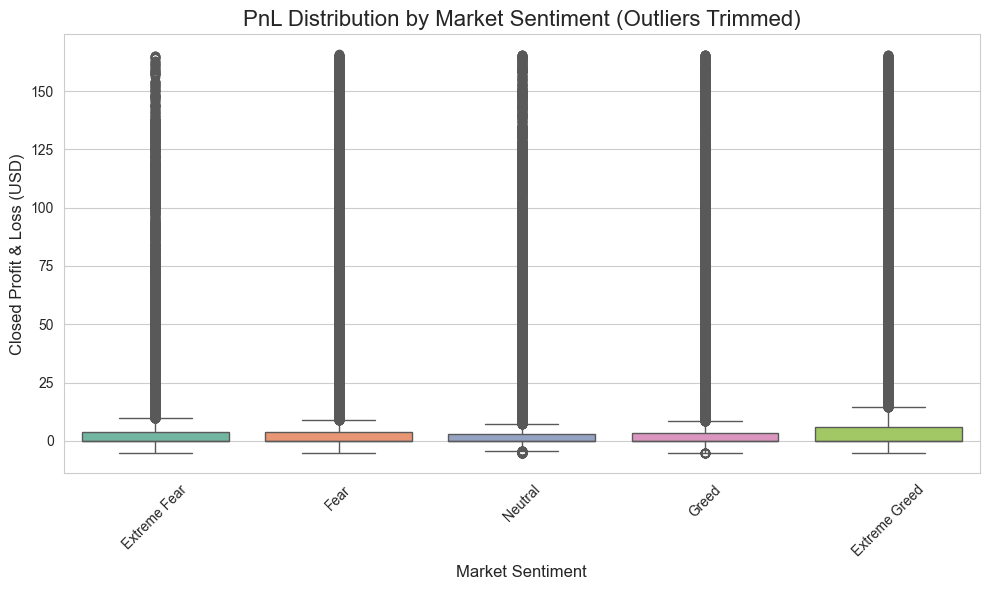

In [73]:
# Create a directory to save our plots
os.makedirs("Outputs", exist_ok=True)

# Plotting the PnL disrtibutions
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='Sentiment', y='PnL', palette='Set2', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('PnL Distribution by Market Sentiment (Outliers Trimmed)', fontsize=16)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Closed Profit & Loss (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig("outputs/pnl_distribution_by_sentiment.png")
plt.show()

#### The boxplot visually confirms our earlier findings. We can see the median PnL (the line inside the box) and the general spread of outcomes. A wider box indicates more variance in PnL for that sentiment.

####  Average PnL & Trade Value by Sentiment
- These bar charts provide a clear, direct comparison of average PnL and average capital deployed (trade value) across the different sentiment phases.



/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_10176/2205394313.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette='coolwarm')


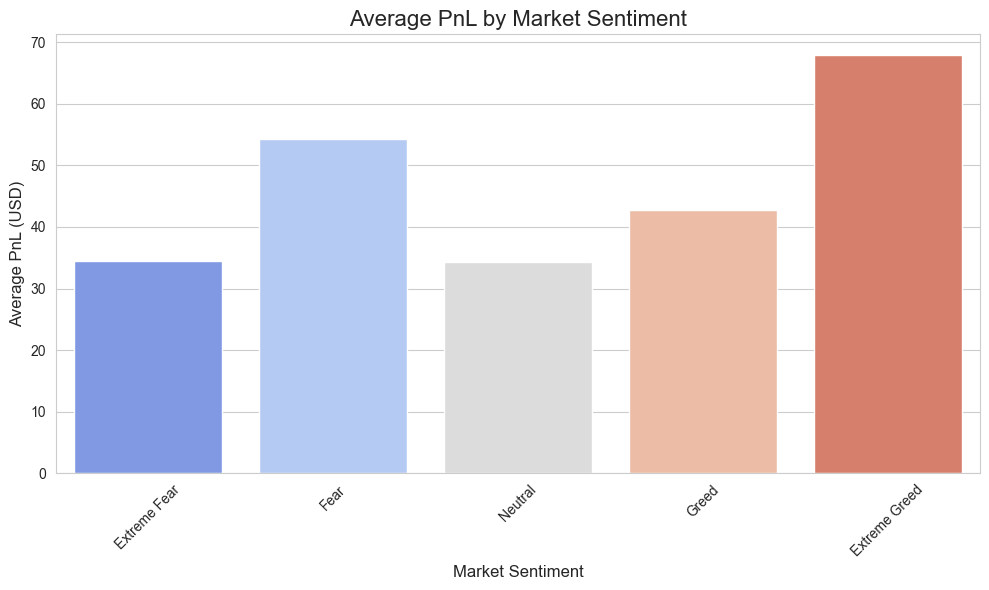

In [74]:
# Plotting Average PnL
avg_pnl = merged_df.groupby('Sentiment')['PnL'].mean().reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette='coolwarm')
plt.title('Average PnL by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Average PnL (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/avg_pnl_by_sentiment.png")
plt.show()

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_10176/135821247.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_volume.index, y=avg_volume.values, palette='viridis')


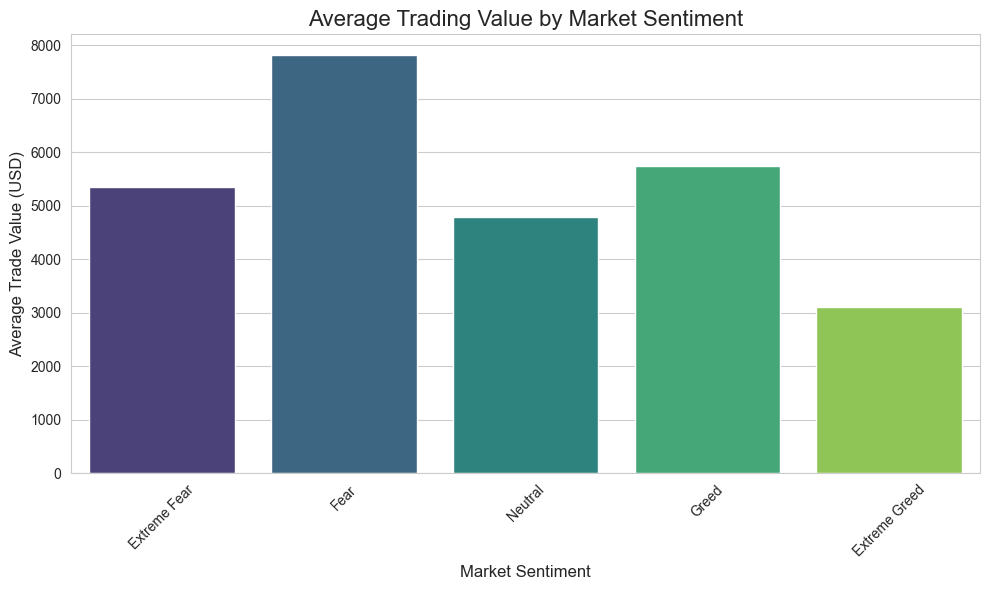

In [75]:
# Plotting Average Trading Value
avg_volume = merged_df.groupby('Sentiment')['TradeValue'].mean().reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_volume.index, y=avg_volume.values, palette='viridis')
plt.title('Average Trading Value by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Average Trade Value (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/avg_trade_value_by_sentiment.png")
plt.show()

#### These charts reveal a fascinating behavioral pattern: the strategy appears to risk more capital during 'Fear' but realizes its highest average profits during 'Extreme Greed'. This could imply a "buy the dip" approach that pays off when the market recovers and becomes euphoric

#### Risk Analysis: PnL Volatility
- We use the standard deviation of PnL as a proxy for risk or volatility. A higher standard deviation means the trade outcomes are more spread out and less predictable.



/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_10176/2804982672.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='PnL_StdDev', data=risk_sentiment, palette='YlOrRd')


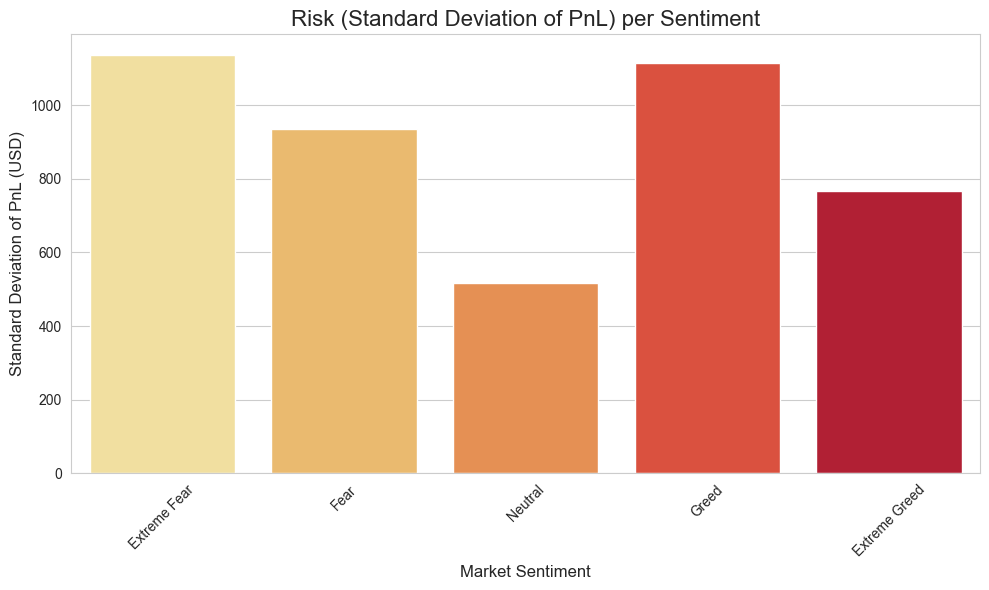

In [76]:
# Group by sentiment and calculate the standard deviation of PnL
risk_sentiment = merged_df.groupby('Sentiment')['PnL'].std().reset_index()
risk_sentiment.columns = ['Sentiment', 'PnL_StdDev']
risk_sentiment = risk_sentiment.set_index('Sentiment').reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='PnL_StdDev', data=risk_sentiment, palette='YlOrRd')
plt.title('Risk (Standard Deviation of PnL) per Sentiment', fontsize=16)
plt.ylabel('Standard Deviation of PnL (USD)', fontsize=12)
plt.xlabel('Market Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/risk_by_sentiment.png")
plt.show()

# Step 6: Uncovering Hidden Trends

- Let's dive deeper to see if profitability differs based on the trade direction (Buy vs. Sell) within each sentiment category.

#### Profitability per Trade Direction vs. Sentiment

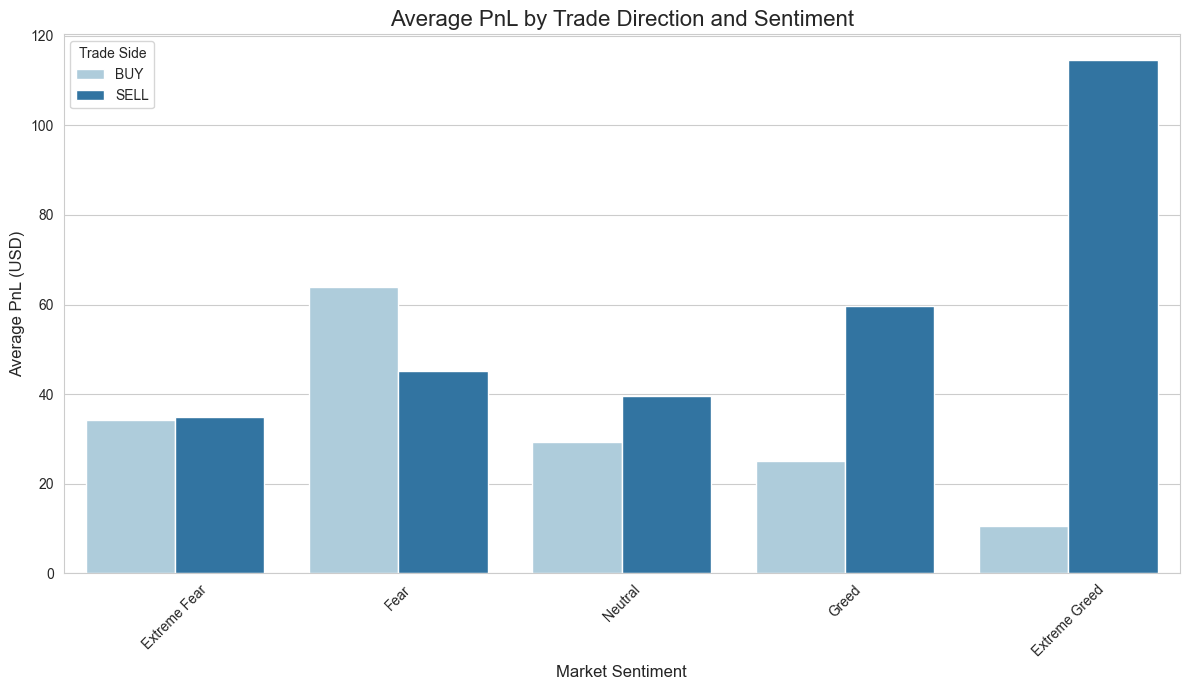

In [77]:
# Average PnL by Sentiment and Side (Buy/Sell)
pnl_by_direction = merged_df.groupby(['Sentiment', 'Side'])['PnL'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(x='Sentiment', y='PnL', hue='Side', data=pnl_by_direction, palette='Paired', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Average PnL by Trade Direction and Sentiment', fontsize=16)
plt.ylabel('Average PnL (USD)', fontsize=12)
plt.xlabel('Market Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Trade Side')
plt.tight_layout()
plt.savefig("outputs/pnl_by_direction_and_sentiment.png")
plt.show()

#### This chart is powerful. It might reveal, for example, that 'Buy' trades are highly profitable during 'Fear' and 'Extreme Fear', while 'Sell' trades perform better during 'Greed', providing highly specific, actionable insights into the trading strategy

#### Volume per Trade vs Sentiment

/var/folders/77/7l14d5v97qzct7c0yxlqb2xr0000gn/T/ipykernel_10176/1458616061.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Size Tokens', data=volume_by_sentiment_tokens, palette='magma')


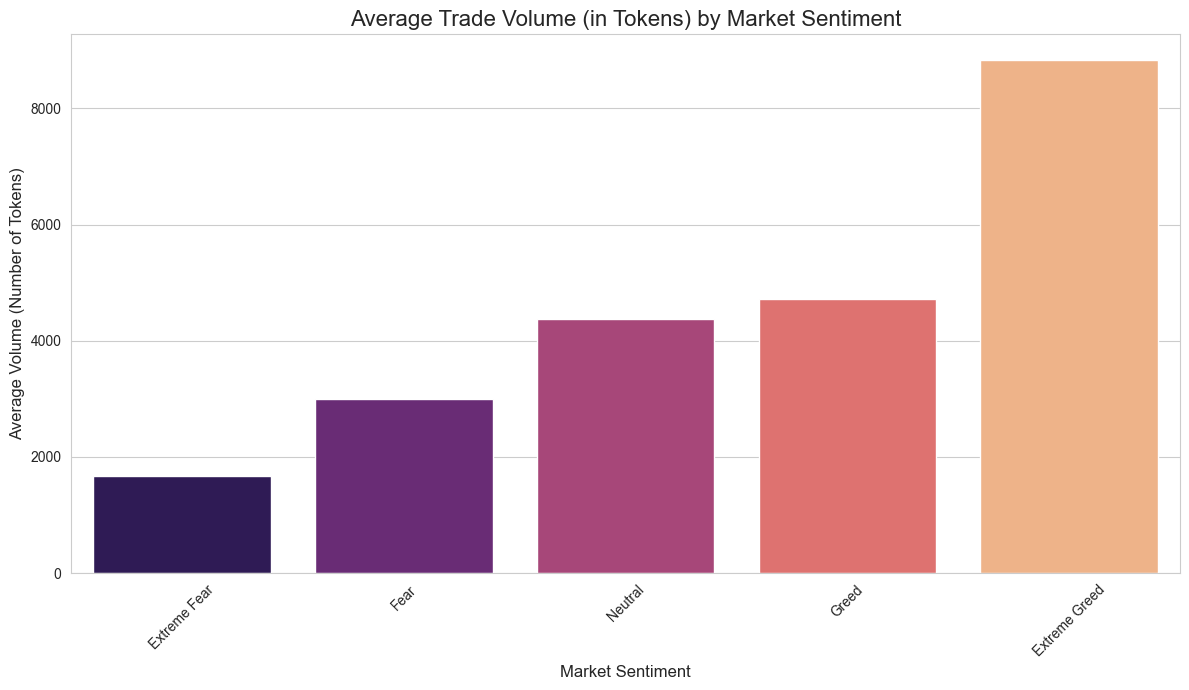

In [78]:
# Group by sentiment and calculate the average trade size in tokens
volume_by_sentiment_tokens = merged_df.groupby('Sentiment')['Size Tokens'].mean().reset_index()
volume_by_sentiment_tokens = volume_by_sentiment_tokens.set_index('Sentiment').reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']).reset_index()

# Plot the results
plt.figure(figsize=(12, 7))
sns.barplot(x='Sentiment', y='Size Tokens', data=volume_by_sentiment_tokens, palette='magma')
plt.title('Average Trade Volume (in Tokens) by Market Sentiment', fontsize=16)
plt.ylabel('Average Volume (Number of Tokens)', fontsize=12)
plt.xlabel('Market Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/avg_token_volume_by_sentiment.png")
plt.show()

#### This chart shows whether you tend to accumulate more of the actual asset during specific market phases. If the number of tokens traded is highest during 'Extreme Fear', it strongly supports the "accumulating when prices are low" hypothesis, as you are getting more of the asset for your capital. Comparing this with the 'Average Trade Value' chart gives a complete picture of your capital and asset allocation strategy.

# Step 7: Conclusion & Future Work


### Summary of Findings
#### This analysis successfully demonstrated a strong correlation between market sentiment and trading behavior/performance. Key takeaways include:

- Peak Profitability in Greed: The strategy's highest average profits were realized during Extreme Greed, capitalizing on market euphoria.

- Increased Risk-Taking in Fear: The largest trades (in USD value) were made during Fear, indicating a counter-cyclical "buy the dip" behavior.

- Directional Biases: The effectiveness of 'Buy' vs. 'Sell' trades varied significantly across different sentiment phases, highlighting opportunities for strategic adjustments.